In [24]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:/Users/Olaf/Documents/studia/BigData/data/tesla_5m_20190201_20190522.csv",
                index_col='datetime', parse_dates=['datetime'])

In [3]:
time = "H"

In [4]:
df = pd.concat([df['open'].resample(time).agg("first"),
    df['close'].resample(time).last(),
    df['high'].resample(time).max(),
    df['low'].resample(time).min(),
    df['marketVolume'].resample(time).sum()], axis=1)

In [5]:
df = df.dropna().copy()

In [6]:
df = add_all_ta_features(df, "open", 'high','low', 'close', 'marketVolume')

C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:605: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:627: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


In [7]:
df['profit'] = df['close'] - df['open']

In [8]:
df['lower_shadow'] = np.minimum(df['open'], df['close']) - df['low']
df['higher_shadow'] = df['high'] - np.maximum(df['open'], df['close'])

In [9]:
df['profit'] = df['profit'].shift(-1)

In [10]:
df = df.dropna(subset=['profit'])

In [11]:
df_test = df.loc['2019-05-15':]
df = df.loc[:'2019-05-21']

In [12]:
X = df.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)
X_test = df_test.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)

In [13]:
y = df['profit']
y_test = df_test['profit']

In [14]:
xgb = XGBRegressor()
cb = CatBoostRegressor(verbose=0, iterations=100)
rf = RandomForestRegressor(n_estimators=100, max_depth=3)
lr = LinearRegression()

In [15]:
def profit(y, y_pred):
    return y[y_pred>0].sum()

In [16]:
prof_scorer = make_scorer(profit)

In [17]:
cb.fit(X,y)

In [18]:
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
df_test['preds'] = cb.predict(X_test)

In [20]:
df_test['profit_model'] = np.where(df_test['preds'] >0, df_test['profit'], -df_test['profit'])

In [21]:
df_test['profit_model'].cumsum().plot()

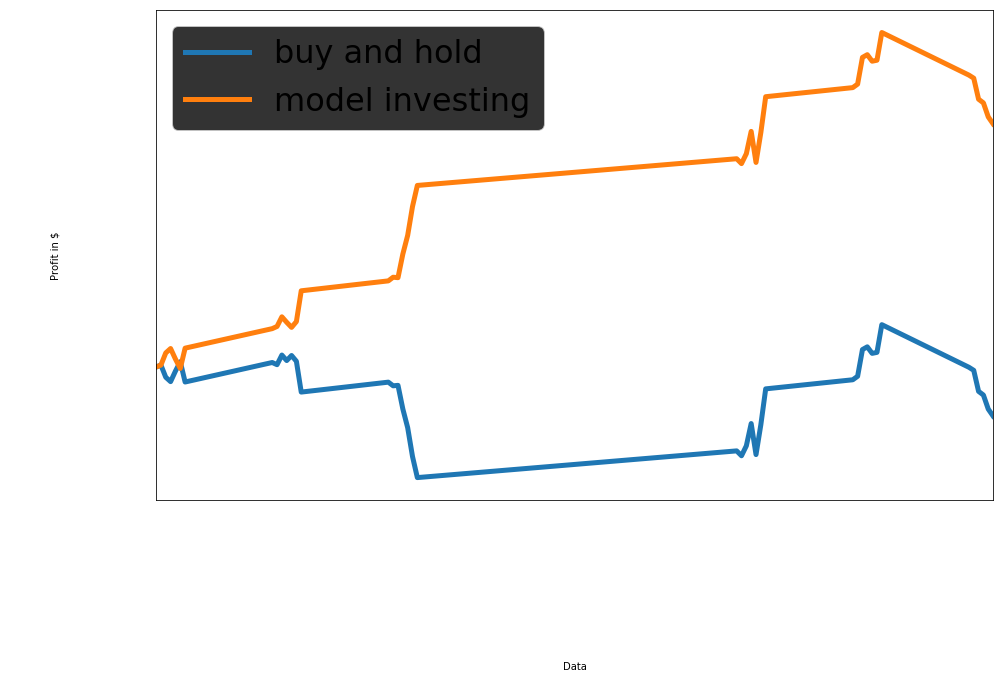

In [25]:
plt.figure(figsize=(15,10))
df_test['profit'].cumsum().plot(label="buy and hold", linewidth=5)
df_test['profit_model'].cumsum().plot(label="model investing", linewidth=5)
plt.legend()
plt.tick_params(colors='white', labelsize=40)
plt.legend(fontsize=32, facecolor="black")
#plt.xaxis.label.set_color('white')
plt.xlabel("Data")
plt.ylabel("Profit in $")
plt.savefig('profit_curve.png', transparent=True, pad_inches=2, bbox_inches = 'tight', dpi=300)

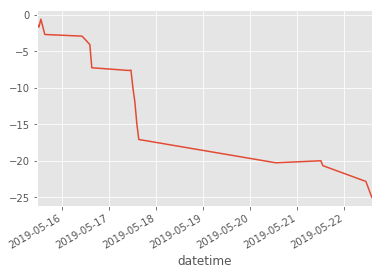

In [29]:
y_test[xgb.predict(X_test) < 0].cumsum().plot()

In [27]:
y_test.mean()

-0.06707317073170871

In [48]:
from sklearn.externals import joblib

In [49]:
joblib.dump(xgb, "xgboost_price.h5")

['xgboost_price.h5']

In [41]:
y_test[cb.predict(X_test) > 0].sum()

12.264999999999986

In [44]:
import shap

In [45]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

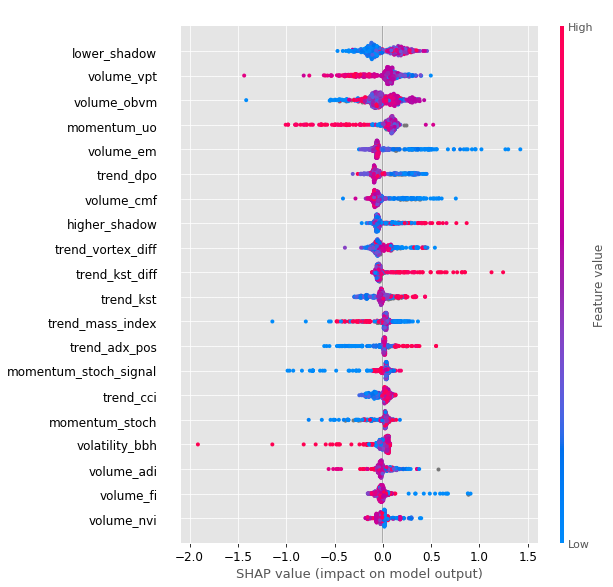

In [46]:
shap.summary_plot(shap_values, X, show=False)
plt.tick_params(colors='black', labelsize=12)
plt.savefig('var_imp.png', transparent=False, pad_inches=2, bbox_inches = 'tight', dpi=300)